In [8]:
import os
from os import listdir
from os.path import isfile, join
import pickle
from utils import *
import json 
import matplotlib.pyplot as plt
from losses import *
from model import  SingleTrialLicks 

#stitch all sessions
path_dandi= '../data/MAPDANDI_Functional/'
directory = os.fsencode(path_dandi)
files_list = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename[30:31]=='.':
        data = pickle.load(open(path_dandi+filename, 'rb'))
        if len(data)>0:
            n_neurons = data['average_trials'].shape[1]
            if n_neurons>0:
                files_list.append(filename)

#loading hiperparameters data
with open('parameters_list.json') as f:
    default_parameters = json.load(f)

n_pop = 12
net = None#'net_ALM_hemi_right8.pth'
hemi = 'right' #training on just left hemisphere neurons
max_epochs = 4
lr=5e-4
c_av = 0.7
c_orth = 500
c_sel = 0.5
test_every = 50
optimize_every = 1


#loading data  
max_time_index = 275 
mean_licks = mean_licks_inputs(files_list, hemi = hemi, max_time_index = max_time_index) 
single_trial_licks = licks_inputs(files_list, max_time_index =  max_time_index)
ALM_hemi= load_me_data(files_list, default_parameters, hemi=hemi, max_time_index=max_time_index)
trial_average = tch.tensor(ALM_hemi['rates'][0:2,:,:], dtype = tch.float32).to(default_parameters['device']).float()
print('dimensions', hemi, trial_average.shape, mean_licks.shape)

dimensions right torch.Size([2, 275, 4244]) torch.Size([2, 275, 4244])


In [ ]:
session_names = ['sub-456772_ses-20191120T115527.p']
#loading data    
total_sessions = len(session_names)
trial_indexes = {}
for ses_name in session_names:
    trial_indexes[ses_name] = ALM_hemi['indexes'][ses_name]
trial_average, trial_types = toch_version_ratates_trial_types(ALM_hemi, default_parameters, session_names)

data_all_spikes = {}
for ses_name in session_names:
    data = pickle.load(open(path_dandi + ses_name.rstrip('p') + '_all_spikes.p', 'rb'))
    data_all_spikess[ses_name] = tch.tensor()

indexes_neurons_st = [ALM_hemi['indexes'][s] for s in session_names]
total_sessions = len(indexes_neurons_st )
st_licks = tch.zeros(single_trial_licks[session_names[0]].shape)


default_parameters['n_latents'] = n_pop
default_parameters['n_neurons'] = ALM_hemi['rates'].shape[2]


#trial average
LossTrials = LossAverageTrials()
losses_trial_av = np.zeros(max_epochs)
#loss on the modes
LossSelectivity = SelectivityLoss(trial_average, default_parameters)
losses_sel = np.zeros(max_epochs)
#loss on the orthogonality of the weights
LossWeights = LossOrthogonality(default_parameters['device']) 
losses_weights = np.zeros(max_epochs)
losses_time_av = np.zeros(max_epochs)
losses_neurons_av = np.zeros(max_epochs)
#Defining losses
#average over time
ListLossesTime = [LossAverageTime(ALM_hemi['indexes'][s], default_parameters) for s in session_names]
#average over neurons
ListLossesNeurons = [LossAverageNeurons(ALM_hemi['indexes'][s]) for s in session_names]


n_trials = 0
for t_type in trial_types:
    n_trials+=len(trial_types[t_type])
default_parameters['n_trials'] = n_trials
net = SingleTrialLicks(default_parameters, indexes_neurons_st)
net.device = default_parameters['device']


epoch=0
min_mean_loss = 10. 
thres_trial_av = 10.
mean_loss = 100.
while epoch<1:
    #adding initial data
    results, cov = net.forward(mean_licks, single_trial_licks, trial_types)
    #Reconsutring neural activity average over trials
    total_trial_average = LossTrials(trial_average, results['rates_alm'])
    losses_trial_av[epoch] = total_trial_average.detach().cpu().numpy()
    
    ##Reconsutring average activity over time
    #total_time_average = 0
    #ind_trial = 0
    #for s in range(len(session_names)):
    #trial indexes to compute
    #   ses_name = session_names[s]
    #    print(ALM_hemi['time_average'][ses_name].shape)
    #    print(results['rates_trials'][:,:,indexes_neurons_st[s]].shape)
        #total_time_average += ListLossesTime[s](ALM_hemi['time_average'][ses_name], results['rates_trials'][:,:,indexes_neurons_st[s]])
        #total_time_average = total_time_average/float(total_sessions)
        #losses_time_av[epoch] = total_time_average .detach().cpu().numpy()
    epoch+=1


torch.Size([5, 243, 109])
torch.Size([243, 275, 109])


In [5]:
path_dandi = '../data/MAPDANDI_Functional/'
data_bh = pickle.load(open(path_dandi+ 'sub-456772_ses-20191120T115527' + '_behavior.p', 'rb'))
data_all_spikes = pickle.load(open(path_dandi+ 'sub-456772_ses-20191120T115527' + '_all_spikes.p', 'rb'))
data_all_spikes.shape

(243, 435, 109)

In [3]:
licks = licks_inputs(files_list, max_time_index = 350, ind_start=50)

In [4]:
licks['sub-456772_ses-20191120T115527.p'].shape

torch.Size([2, 243, 350])

In [8]:
data_ses = load_me_data(['sub-456772_ses-20191120T115527.p'], default_parameters, hemi = 'left', max_time_index=350)

In [9]:
data_ses['n_trials']

array([243])

In [10]:
data_bh['inds_good_trials'].shape

(243,)

In [16]:
data_bh.keys()

dict_keys(['inds_left_hit', 'inds_right_hit', 'inds_good_trials', 'trial_type', 'trial_responses', 'time_left_licks', 'time_right_licks', 'rates_left_licks', 'rates_right_licks', 'jaw_time_series', 'nose_time_series', 'time_jaw', 'time_nose', 'bins'])

In [2]:
mean_licks.shape

torch.Size([2, 275, 4244])

In [4]:
single_trial_licks['sub-456772_ses-20191120T115527.p'].shape

torch.Size([2, 243, 275])

In [24]:
results['latents_trials'].shape

torch.Size([243, 275, 12])

In [7]:
ALM_hemi['neurons_average'][session_names[0]].shape

torch.Size([243, 435])

In [4]:
session_names

NameError: name 'session_names' is not defined

In [10]:
ALM_hemi['time_average']['sub-456774_ses-20191021T142044.p'].shape

torch.Size([5, 236, 57])

In [7]:
ALM_hemi['rates'].shape

(2, 275, 4244)

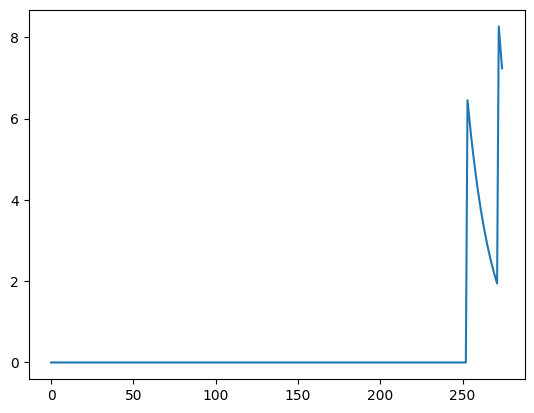

In [ ]:
ind = 90

plt.plot(single_trial_licks['sub-456774_ses-20191023T142402.p'].detach().cpu().numpy()[0,ind,:])
#plt.plot(single_trial_licks['sub-456774_ses-20191023T142402.p'].detach().cpu().numpy()[1,ind,:])

In [17]:
single_trial_licks['sub-456774_ses-20191023T142402.p'].shape

torch.Size([2, 307, 275])